# Big Bang: Slow-Motion First Steps

**Question:** What happens in the first moments of training that produces such violent token motion?

Intuition says: if weights are initialized from a small Gaussian (~0.02 std), logits should be small (dot products of near-orthogonal vectors), probabilities should be uniform-ish, and gradients should be modest.

Instead, we see tokens teleporting thousands of lattice cells on step 1.

This notebook steps through the first 10 training steps one Planck-second at a time, examining:
- Hidden states: what magnitudes? what distribution?
- Logits: how big? how spread?
- Probabilities: how confident is the model?
- Loss: how wrong?
- Gradients: how big? which direction?
- Updates: how far do tokens actually move?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Style
plt.rcParams['figure.dpi'] = 150
STEELBLUE = '#4682B4'

Using device: mps


## Parameters

Matching Crucible settings exactly.

In [2]:
# Model architecture (matches Crucible/Flannel)
VOCAB_SIZE = 10000
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 2
SEQ_LEN = 128

# Training (matches Crucible)
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

# Initialization
INIT_STD = 0.02

print(f"Model: {VOCAB_SIZE} vocab, {HIDDEN_DIM}D hidden, {NUM_LAYERS} layers")
print(f"Training: lr={LEARNING_RATE}, batch={BATCH_SIZE}")
print(f"Init: Gaussian with std={INIT_STD}")

Model: 10000 vocab, 64D hidden, 2 layers
Training: lr=0.001, batch=128
Init: Gaussian with std=0.02


## Model Definition

In [3]:
class TinyLM(nn.Module):
    """Minimal transformer LM matching Crucible architecture."""
    
    def __init__(self, vocab_size, hidden_dim, num_layers, num_heads, seq_len, init_std):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        # Embeddings - we'll initialize these explicitly in the next cell
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(seq_len, hidden_dim)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.0,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(hidden_dim)
        
    def forward(self, input_ids, return_hidden=False):
        batch_size, seq_len = input_ids.shape
        
        # Embeddings
        tok_emb = self.embedding(input_ids)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_embedding(pos_ids)
        hidden = tok_emb + pos_emb
        
        # Transformer
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=input_ids.device)
        hidden = self.transformer(hidden, mask=causal_mask, is_causal=True)
        hidden = self.ln_f(hidden)
        
        # Logits via weight tying
        logits = hidden @ self.embedding.weight.T
        
        if return_hidden:
            return logits, hidden
        return logits

# Create model (don't initialize yet)
model = TinyLM(VOCAB_SIZE, HIDDEN_DIM, NUM_LAYERS, NUM_HEADS, SEQ_LEN, INIT_STD)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 748,288 parameters


/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## Explicit Initialization

Initialize all weights from Gaussian(0, 0.02). This is the moment of creation.

In [4]:
# Reset seed for reproducible initialization
torch.manual_seed(SEED)

# Initialize embedding weights explicitly
with torch.no_grad():
    # Token embeddings: [10000, 64] from N(0, 0.02)
    model.embedding.weight.data = torch.randn(VOCAB_SIZE, HIDDEN_DIM) * INIT_STD
    
    # Position embeddings: [128, 64] from N(0, 0.02)
    model.pos_embedding.weight.data = torch.randn(SEQ_LEN, HIDDEN_DIM) * INIT_STD

# Verify initialization
W = model.embedding.weight.data
print(f"Embedding W initialized:")
print(f"  Shape: {W.shape}")
print(f"  Mean: {W.mean().item():.6f} (expected: ~0)")
print(f"  Std: {W.std().item():.6f} (expected: ~{INIT_STD})")
print(f"  Min: {W.min().item():.6f}")
print(f"  Max: {W.max().item():.6f}")

# What's the typical norm of a token embedding?
norms = W.norm(dim=1)
print(f"\nToken embedding norms:")
print(f"  Mean: {norms.mean().item():.4f}")
print(f"  Std: {norms.std().item():.4f}")
print(f"  Expected (√D × std): {np.sqrt(HIDDEN_DIM) * INIT_STD:.4f}")

Embedding W initialized:
  Shape: torch.Size([10000, 64])
  Mean: -0.000041 (expected: ~0)
  Std: 0.020019 (expected: ~0.02)
  Min: -0.092176
  Max: 0.096604

Token embedding norms:
  Mean: 0.1595
  Std: 0.0141
  Expected (√D × std): 0.1600


## Load Training Data

In [5]:
from tokenizers import Tokenizer
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent
CORPUS_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_model_corpus.txt'
TOKENIZER_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_tokenizer_chars.json'
DEAD_MASK_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Flannel' / 'live_dead_tokens.safetensors'

# Load tokenizer
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))
print(f"Tokenizer vocab size: {tokenizer.get_vocab_size()}")

# Load dead token mask
masks = load_file(str(DEAD_MASK_PATH))
dead_mask = masks['dead_mask'].bool()
dead_indices = masks['dead_indices'].long()
n_dead = dead_mask.sum().item()
print(f"Dead tokens: {n_dead}, Live tokens: {VOCAB_SIZE - n_dead}")

# Simple dataset
class TextDataset(Dataset):
    def __init__(self, corpus_path, tokenizer, seq_len):
        with open(corpus_path, 'r') as f:
            text = f.read()
        self.tokens = tokenizer.encode(text).ids
        self.seq_len = seq_len
        self.n_sequences = len(self.tokens) // seq_len
        
    def __len__(self):
        return self.n_sequences
    
    def __getitem__(self, idx):
        start = idx * self.seq_len
        return torch.tensor(self.tokens[start:start + self.seq_len], dtype=torch.long)

dataset = TextDataset(CORPUS_PATH, tokenizer, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Dataset: {len(dataset)} sequences")

Tokenizer vocab size: 10000
Dead tokens: 3699, Live tokens: 6301
Dataset: 10713 sequences


## Setup for Training

Move model to device, create optimizer, get first batch.

In [6]:
# Move to device and convert to bfloat16
model = model.to(device).to(torch.bfloat16)
model.train()

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2),
    eps=EPSILON,
    weight_decay=WEIGHT_DECAY
)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Get an iterator for batches
batch_iter = iter(dataloader)

print("Ready for Big Bang.")

Ready for Big Bang.


---

# Step 0: The Universe Before Time

Before any training. What does the model look like at initialization?

In [7]:
# Get a batch (don't train yet, just look)
batch = next(batch_iter).to(device)
input_ids = batch
print(f"Batch shape: {input_ids.shape}")
print(f"Batch token range: [{input_ids.min().item()}, {input_ids.max().item()}]")

# Forward pass WITHOUT gradient tracking
with torch.no_grad():
    logits, hidden = model(input_ids, return_hidden=True)

print(f"\n--- Hidden States ---")
print(f"Shape: {hidden.shape}")  # [batch, seq, hidden]
hidden_flat = hidden.float().view(-1, HIDDEN_DIM)
print(f"Mean: {hidden_flat.mean().item():.6f}")
print(f"Std: {hidden_flat.std().item():.6f}")
hidden_norms = hidden_flat.norm(dim=1)
print(f"Norm - Mean: {hidden_norms.mean().item():.4f}, Std: {hidden_norms.std().item():.4f}")

print(f"\n--- Logits ---")
print(f"Shape: {logits.shape}")  # [batch, seq, vocab]
logits_flat = logits.float().view(-1, VOCAB_SIZE)
print(f"Mean: {logits_flat.mean().item():.6f}")
print(f"Std: {logits_flat.std().item():.6f}")
print(f"Min: {logits_flat.min().item():.4f}")
print(f"Max: {logits_flat.max().item():.4f}")

print(f"\n--- Probabilities (softmax of logits) ---")
probs = F.softmax(logits_flat, dim=-1)
print(f"Max prob (most confident prediction): {probs.max().item():.6f}")
print(f"Min prob: {probs.min().item():.2e}")
# Effective number of choices (perplexity of uniform would be 10000)
entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=-1)
perplexity = torch.exp(entropy)
print(f"Mean perplexity: {perplexity.mean().item():.1f} (uniform would be {VOCAB_SIZE})")

print(f"\n--- What would the loss be? ---")
shift_logits = logits[:, :-1, :].contiguous().view(-1, VOCAB_SIZE)
shift_labels = input_ids[:, 1:].contiguous().view(-1)
loss = loss_fn(shift_logits.float(), shift_labels)
print(f"Cross-entropy loss: {loss.item():.4f}")
print(f"Theoretical minimum (uniform): {np.log(VOCAB_SIZE):.4f}")

Batch shape: torch.Size([128, 128])
Batch token range: [3, 9999]

--- Hidden States ---
Shape: torch.Size([128, 128, 64])
Mean: 0.000000
Std: 0.999976
Norm - Mean: 7.9998, Std: 0.0029

--- Logits ---
Shape: torch.Size([128, 128, 10000])
Mean: 0.000347
Std: 0.160448
Min: -0.8438
Max: 0.8945

--- Probabilities (softmax of logits) ---
Max prob (most confident prediction): 0.000241
Min prob: 4.24e-05
Mean perplexity: 9872.1 (uniform would be 10000)

--- What would the loss be? ---
Cross-entropy loss: 9.2292
Theoretical minimum (uniform): 9.2103


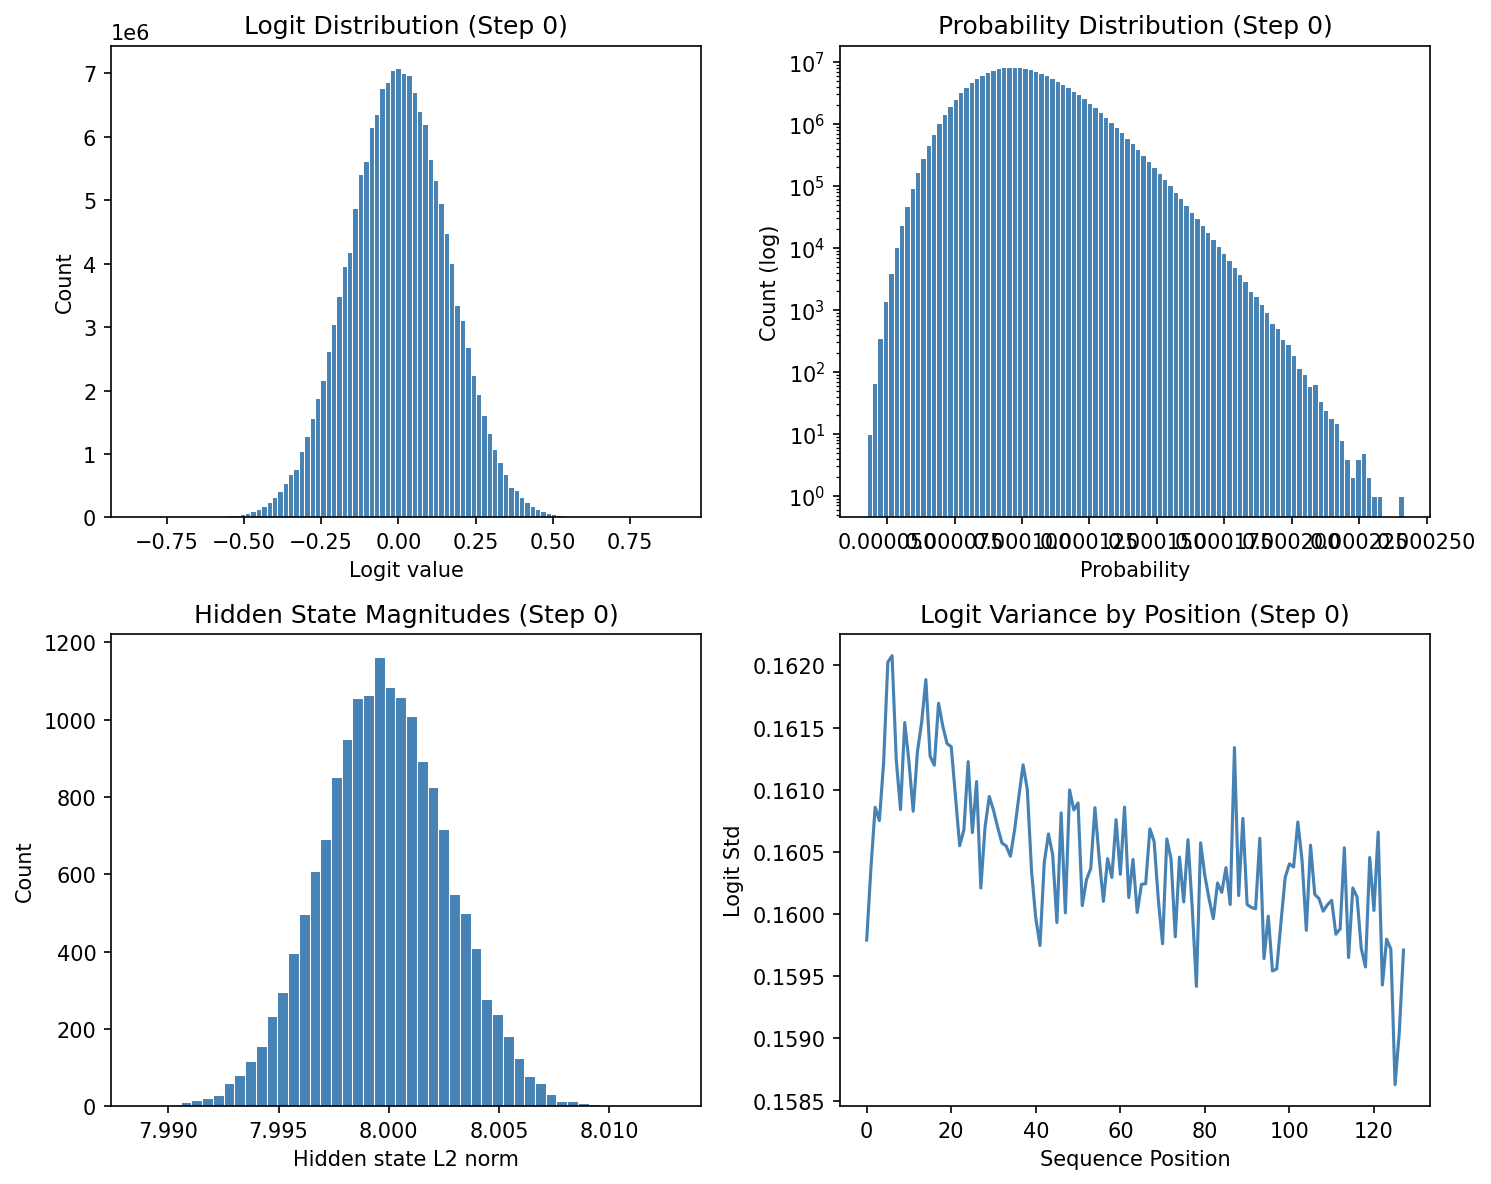

In [8]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Logit distribution
ax = axes[0, 0]
ax.hist(logits_flat.cpu().numpy().flatten(), bins=100, color=STEELBLUE, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Logit value')
ax.set_ylabel('Count')
ax.set_title('Logit Distribution (Step 0)')

# Probability distribution (log scale)
ax = axes[0, 1]
ax.hist(probs.cpu().numpy().flatten(), bins=100, color=STEELBLUE, edgecolor='white', linewidth=0.5, log=True)
ax.set_xlabel('Probability')
ax.set_ylabel('Count (log)')
ax.set_title('Probability Distribution (Step 0)')

# Hidden state norms
ax = axes[1, 0]
ax.hist(hidden_norms.cpu().numpy(), bins=50, color=STEELBLUE, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Hidden state L2 norm')
ax.set_ylabel('Count')
ax.set_title('Hidden State Magnitudes (Step 0)')

# Per-position logit std (does position matter?)
ax = axes[1, 1]
logit_std_by_pos = logits.float().std(dim=(0, 2)).cpu().numpy()  # std across batch and vocab, per position
ax.plot(logit_std_by_pos, color=STEELBLUE)
ax.set_xlabel('Sequence Position')
ax.set_ylabel('Logit Std')
ax.set_title('Logit Variance by Position (Step 0)')

plt.tight_layout()
plt.show()

---

# Step 1: The Big Bang

The first training step. What happens?

In [9]:
# Capture W before the step
W_before = model.embedding.weight.detach().cpu().clone()

# Forward pass WITH gradients
with torch.autocast(device_type='cpu', dtype=torch.bfloat16):  # MPS doesn't support autocast well
    logits = model(input_ids)
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    loss = loss_fn(shift_logits.view(-1, VOCAB_SIZE).float(), shift_labels.view(-1))

print(f"Step 1 Forward Pass:")
print(f"  Loss: {loss.item():.4f}")

Step 1 Forward Pass:
  Loss: 9.2292


In [10]:
# Backward pass
optimizer.zero_grad()
loss.backward()

# Examine gradients BEFORE optimizer step
grad = model.embedding.weight.grad.detach().cpu().float()

print(f"\n--- Gradients (before optimizer) ---")
print(f"Shape: {grad.shape}")
print(f"Mean: {grad.mean().item():.2e}")
print(f"Std: {grad.std().item():.2e}")
print(f"Min: {grad.min().item():.2e}")
print(f"Max: {grad.max().item():.2e}")

# Gradient norms per token
grad_norms = grad.norm(dim=1)
print(f"\nPer-token gradient norms:")
print(f"  Mean: {grad_norms.mean().item():.2e}")
print(f"  Std: {grad_norms.std().item():.2e}")
print(f"  Max: {grad_norms.max().item():.2e}")

# Dead vs live token gradients
dead_grad_norms = grad_norms[dead_mask]
live_grad_norms = grad_norms[~dead_mask]
print(f"\nDead token gradient norms: mean={dead_grad_norms.mean().item():.2e}")
print(f"Live token gradient norms: mean={live_grad_norms.mean().item():.2e}")


--- Gradients (before optimizer) ---
Shape: torch.Size([10000, 64])
Mean: -1.64e-09
Std: 5.13e-04
Min: -4.88e-02
Max: 4.93e-02

Per-token gradient norms:
  Mean: 9.65e-04
  Std: 3.99e-03
  Max: 1.94e-01

Dead token gradient norms: mean=5.42e-04
Live token gradient norms: mean=1.21e-03


In [11]:
# Optimizer step
optimizer.step()

# Capture W after the step
W_after = model.embedding.weight.detach().cpu().clone()

# Compute displacement
delta_W = (W_after.float() - W_before.float())
delta_W_norm = delta_W.norm(dim=1)

print(f"\n--- Weight Update ---")
print(f"Mean |ΔW|: {delta_W_norm.mean().item():.2e}")
print(f"Max |ΔW|: {delta_W_norm.max().item():.2e}")

# Dead vs live
dead_delta_norms = delta_W_norm[dead_mask]
live_delta_norms = delta_W_norm[~dead_mask]
print(f"\nDead token |ΔW|: mean={dead_delta_norms.mean().item():.2e}")
print(f"Live token |ΔW|: mean={live_delta_norms.mean().item():.2e}")

# In lattice units (ULP)
# For bfloat16, ULP at magnitude ~0.02 is about 2^(-7-7) = 2^-14 ≈ 6e-5
# Actually let's compute it properly
def compute_ulp_bf16(tensor):
    tensor_bf16 = tensor.to(torch.bfloat16)
    bits = tensor_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return ulp

ulp_before = compute_ulp_bf16(W_before)
delta_W_prime = delta_W / ulp_before  # Displacement in lattice cells
delta_W_prime_L2 = delta_W_prime.norm(dim=1)

print(f"\n--- Displacement in Lattice Cells (ΔW′) ---")
print(f"Mean |ΔW′|: {delta_W_prime_L2.mean().item():.1f}")
print(f"Max |ΔW′|: {delta_W_prime_L2.max().item():.1f}")

dead_delta_prime = delta_W_prime_L2[dead_mask]
# Filter out inf values (from near-zero weights)
dead_delta_prime_finite = dead_delta_prime[torch.isfinite(dead_delta_prime)]
print(f"\nDead tokens |ΔW′|: mean={dead_delta_prime_finite.mean().item():.1f}, max={dead_delta_prime_finite.max().item():.1f}")


--- Weight Update ---
Mean |ΔW|: 7.90e-03
Max |ΔW|: 7.98e-03

Dead token |ΔW|: mean=7.90e-03
Live token |ΔW|: mean=7.90e-03

--- Displacement in Lattice Cells (ΔW′) ---
Mean |ΔW′|: 7762.6
Max |ΔW′|: 34340680.0

Dead tokens |ΔW′|: mean=13295.4, max=34340680.0


### Step 1 Analysis

Let's understand WHY the gradients are so large.

In [12]:
# The gradient for token j in the embedding matrix comes from:
# ∂L/∂W_j = sum over all positions where token j is predicted or is the target
#
# For the cross-entropy loss with softmax:
# ∂L/∂logit_k = p_k - 1{k=target}
#
# So if the model predicts token k with probability p_k, the gradient magnitude
# for that token's embedding is proportional to |p_k - target|.
#
# Dead tokens never appear as targets, so they only get the p_k part.
# If p_k is uniform (1/10000 ≈ 1e-4), gradients should be small.
# But if some logits are larger, their p_k could be substantial.

# Let's look at the softmax probabilities more carefully
with torch.no_grad():
    logits_check = model(input_ids)
    probs_check = F.softmax(logits_check.float(), dim=-1)  # [batch, seq, vocab]

# What's the probability mass on dead tokens?
dead_probs = probs_check[:, :, dead_mask]  # [batch, seq, n_dead]
print(f"Probability mass on dead tokens:")
print(f"  Mean per position: {dead_probs.sum(dim=-1).mean().item():.4f}")
print(f"  Max prob for any dead token: {dead_probs.max().item():.6f}")

# What's the probability mass on live tokens?
live_probs = probs_check[:, :, ~dead_mask]  # [batch, seq, n_live]
print(f"\nProbability mass on live tokens:")
print(f"  Mean per position: {live_probs.sum(dim=-1).mean().item():.4f}")
print(f"  Max prob for any live token: {live_probs.max().item():.6f}")

Probability mass on dead tokens:
  Mean per position: 0.3661
  Max prob for any dead token: 0.000216

Probability mass on live tokens:
  Mean per position: 0.6339
  Max prob for any live token: 0.000219


---

# Steps 2-10: Watching the Universe Cool

In [13]:
# Track metrics over steps
metrics = {
    'step': [1],  # We already did step 1
    'loss': [loss.item()],
    'grad_norm_dead': [dead_grad_norms.mean().item()],
    'grad_norm_live': [live_grad_norms.mean().item()],
    'delta_norm_dead': [dead_delta_norms.mean().item()],
    'delta_norm_live': [live_delta_norms.mean().item()],
    'delta_prime_dead': [dead_delta_prime_finite.mean().item()],
    'logit_std': [logits.float().std().item()],
    'max_prob': [probs_check.max().item()],
}

# Steps 2-10
for step in range(2, 11):
    # Get next batch
    try:
        batch = next(batch_iter)
    except StopIteration:
        batch_iter = iter(dataloader)
        batch = next(batch_iter)
    input_ids = batch.to(device)
    
    # Capture W before
    W_before = model.embedding.weight.detach().cpu().clone()
    
    # Forward
    logits = model(input_ids)
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    loss = loss_fn(shift_logits.view(-1, VOCAB_SIZE).float(), shift_labels.view(-1))
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    
    grad = model.embedding.weight.grad.detach().cpu().float()
    grad_norms = grad.norm(dim=1)
    
    # Optimizer step
    optimizer.step()
    
    # Capture W after
    W_after = model.embedding.weight.detach().cpu().clone()
    delta_W = (W_after.float() - W_before.float())
    delta_W_norm = delta_W.norm(dim=1)
    
    # Lattice displacement
    ulp = compute_ulp_bf16(W_before)
    delta_W_prime = delta_W / ulp
    delta_W_prime_L2 = delta_W_prime.norm(dim=1)
    
    # Probabilities
    with torch.no_grad():
        probs = F.softmax(logits.float(), dim=-1)
    
    # Record metrics
    dead_grad = grad_norms[dead_mask]
    live_grad = grad_norms[~dead_mask]
    dead_delta = delta_W_norm[dead_mask]
    live_delta = delta_W_norm[~dead_mask]
    dead_delta_prime = delta_W_prime_L2[dead_mask]
    dead_delta_prime_finite = dead_delta_prime[torch.isfinite(dead_delta_prime)]
    
    metrics['step'].append(step)
    metrics['loss'].append(loss.item())
    metrics['grad_norm_dead'].append(dead_grad.mean().item())
    metrics['grad_norm_live'].append(live_grad.mean().item())
    metrics['delta_norm_dead'].append(dead_delta.mean().item())
    metrics['delta_norm_live'].append(live_delta.mean().item())
    metrics['delta_prime_dead'].append(dead_delta_prime_finite.mean().item())
    metrics['logit_std'].append(logits.float().std().item())
    metrics['max_prob'].append(probs.max().item())
    
    print(f"Step {step}: loss={loss.item():.4f}, |ΔW′|_dead={dead_delta_prime_finite.mean().item():.1f}")

print("\nDone.")

Step 2: loss=9.1606, |ΔW′|_dead=2914.8
Step 3: loss=9.0996, |ΔW′|_dead=4940.2
Step 4: loss=9.0348, |ΔW′|_dead=2724.9
Step 5: loss=8.9731, |ΔW′|_dead=6167.6
Step 6: loss=8.9114, |ΔW′|_dead=2775.0
Step 7: loss=8.8477, |ΔW′|_dead=3306.7
Step 8: loss=8.7884, |ΔW′|_dead=3023.3
Step 9: loss=8.7265, |ΔW′|_dead=3563.1
Step 10: loss=8.6724, |ΔW′|_dead=3491.2

Done.


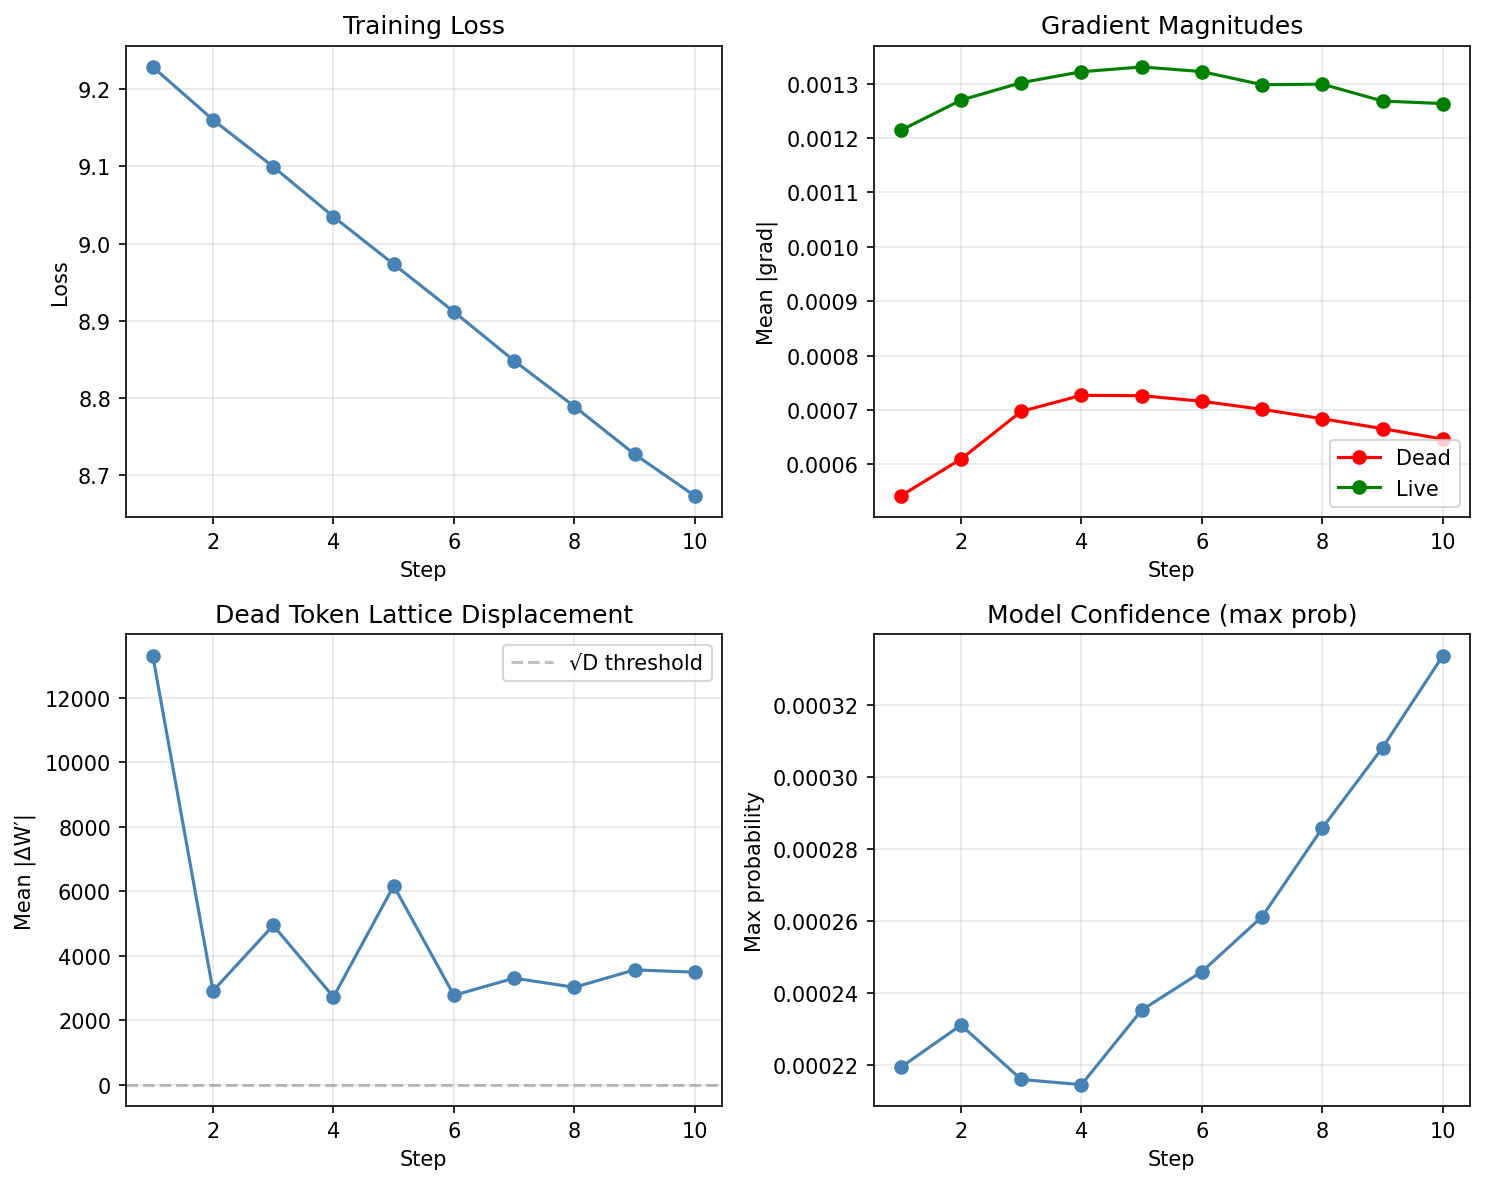

In [14]:
# Plot the evolution
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

steps = metrics['step']

# Loss
ax = axes[0, 0]
ax.plot(steps, metrics['loss'], 'o-', color=STEELBLUE)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)

# Gradient norms
ax = axes[0, 1]
ax.plot(steps, metrics['grad_norm_dead'], 'o-', label='Dead', color='red')
ax.plot(steps, metrics['grad_norm_live'], 'o-', label='Live', color='green')
ax.set_xlabel('Step')
ax.set_ylabel('Mean |grad|')
ax.set_title('Gradient Magnitudes')
ax.legend()
ax.grid(True, alpha=0.3)

# Lattice displacement (dead tokens)
ax = axes[1, 0]
ax.plot(steps, metrics['delta_prime_dead'], 'o-', color=STEELBLUE)
ax.set_xlabel('Step')
ax.set_ylabel('Mean |ΔW′|')
ax.set_title('Dead Token Lattice Displacement')
ax.axhline(y=8, color='gray', linestyle='--', alpha=0.5, label='√D threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Max probability (confidence)
ax = axes[1, 1]
ax.plot(steps, metrics['max_prob'], 'o-', color=STEELBLUE)
ax.set_xlabel('Step')
ax.set_ylabel('Max probability')
ax.set_title('Model Confidence (max prob)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Observations

*(To be filled in after running)*